# Transfer learning với Tensorflow : Feature extraction

## 0. Setting up

In [1]:
# Import libraries
import os
import glob
import sys
import platform
import itertools
import datetime
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


try:
  import tensorflow as tf
  import tensorflow_hub as hub
  import tensorflow.keras
  assert int(tf.__version__.split(".")[1]) >= 10, "tensorflow version should be 2.10+"
except:
  print("Updating tensorflow...")
  # For windows
  #!pip3 install --upgrade tensorflow
  # For macos
  !pip3 install tensorflow-macos==2.10.0
  import tensorflow as tf
  import tensorflow_hub as hub
  import tensorflow.keras

if not os.path.exists("tf_cv_helper.py"):
    !wget https://raw.githubusercontent.com/ngohongthai/ml_helper/main/tf_cv_helper.py
else:
    print("[INFO] 'tf_cv_helper.py' already exists, skipping download.")

from tf_cv_helper import *

# Sử dụng trong file notebook để auto reload những thay đổi có trong file helper (nếu có)
%reload_ext autoreload
%autoreload 2

# Ignore warning
import warnings
warnings.filterwarnings('ignore')

print_env_info()

[INFO] 'tf_cv_helper.py' already exists, skipping download.


#-------------- ENVIRONMENT ---------------#
Python Platform: macOS-13.1-arm64-arm-64bit
Python 3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:48:25) 
[Clang 14.0.6 ]
Tensor Flow Version: 2.10.0
Tensor Flow Hub Version: 0.12.0
Keras Version: 2.10.0
GPU is available
#-------------------------------------------#


## Download data và khám phá dữ liệu

In [2]:
data_url = "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip"
data_dir = download_data(data_url, '10_food_classes_10_percent.zip')
data_dir

168546183/168546183 [==============================] - 17s 0us/step


'./datasets/10_food_classes_10_percent'

In [3]:
print_tree(data_dir)

10_food_classes_10_percent/ (2 files)
      test/ (10 files)
            ice_cream/ (250 files)
            chicken_curry/ (250 files)
            steak/ (250 files)
            sushi/ (250 files)
            chicken_wings/ (250 files)
            grilled_salmon/ (250 files)
            hamburger/ (250 files)
            pizza/ (250 files)
            ramen/ (250 files)
            fried_rice/ (250 files)
      train/ (10 files)
            ice_cream/ (75 files)
            chicken_curry/ (75 files)
            steak/ (75 files)
            sushi/ (75 files)
            chicken_wings/ (75 files)
            grilled_salmon/ (75 files)
            hamburger/ (75 files)
            pizza/ (75 files)
            ramen/ (75 files)
            fried_rice/ (75 files)


array([PosixPath('datasets/10_food_classes_10_percent/test/fried_rice/318527.jpg'),
       PosixPath('datasets/10_food_classes_10_percent/test/hamburger/83196.jpg'),
       PosixPath('datasets/10_food_classes_10_percent/test/ramen/102235.jpg'),
       PosixPath('datasets/10_food_classes_10_percent/test/chicken_curry/1134602.jpg'),
       PosixPath('datasets/10_food_classes_10_percent/train/grilled_salmon/843693.jpg'),
       PosixPath('datasets/10_food_classes_10_percent/test/chicken_wings/1130100.jpg')],
      dtype=object)

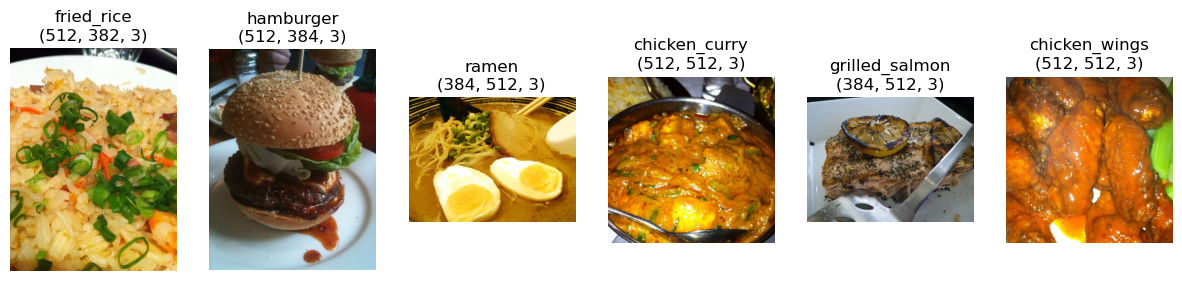

In [4]:
view_random_images(data_dir, 6)

## Experiment

### baseline

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

experiment_name = 'baseline'
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
learning_rate = 1e-3
epochs = 5
experiment_description = """
Mô hình CNN cơ bản
- IMAGE_SIZE = (224, 224)
- BATCH_SIZE = 32
- Data augmentation = False
- Learning rate = 1e-3
- Epochs = 5
"""

#### Prepare datasets

In [8]:
train_dir = data_dir+'/train'
test_dir = data_dir+'/test'
train_data, val_data, test_data = create_datasets(
    train_dir,
    test_dir,
    IMAGE_SIZE,
    BATCH_SIZE
)

Found 750 files belonging to 10 classes.
Using 600 files for training.
Using 150 files for validation.
Found 2500 files belonging to 10 classes.


In [ ]:
class_names = train_data.class_names
class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

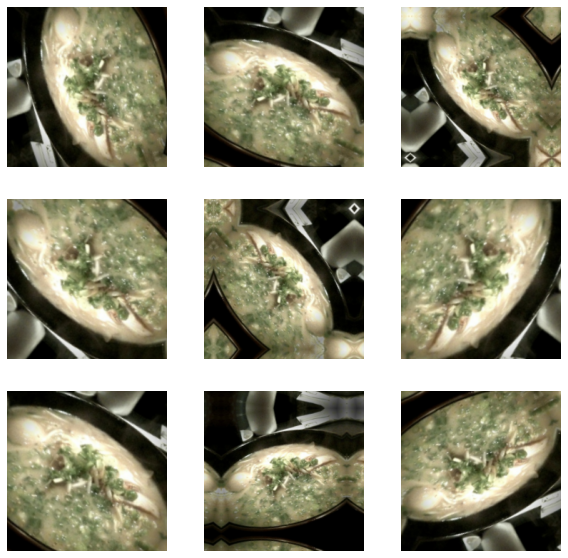

In [ ]:
# Create preprocessing layer
preprocessing_layer = create_preprocessing_layer(data_augmentation=True, data_normalization = False)

plt.figure(figsize=(10, 10))
for images, _ in train_data.take(1):
    for i in range(9):
        augmented_images = preprocessing_layer(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
# Apply `data_augmentation` to the training images.
train_data = train_data.map(
    lambda img, label: (preprocessing_layer(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_data = train_data.prefetch(tf.data.AUTOTUNE)
val_data = val_data.prefetch(tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
from tensorflow import keras
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


baseline = make_model(input_shape=IMAGE_SIZE + (3,), num_classes=len(class_names))

In [ ]:
baseline.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_data,
    epochs=epochs,
    validation_data=val_data,
)

RuntimeError: ignored